In [ ]:
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)

import pickle
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from datetime import datetime as dt

from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score,roc_auc_score,log_loss
from scipy import stats

from flaml import AutoML
from flaml.automl.model import XGBoostEstimator

In [ ]:
np.random.seed(42)

In [ ]:
## NOTE that all feature engineering functions can be found in doordash_feature_eng.py
train_df = pd.read_csv('train_df.csv')
train_df = train_df.drop(columns=['Unnamed: 0','latest_update'])

In [ ]:
def createBaseline(historical_data:pd.DataFrame) -> pd.DataFrame:
    assert 'actual_total_delivery_duration' in historical_data.columns; 'Column actual_total_delivery_duration is not in the given DataFrame. Ensure that addFeatures_durations() was run on the provided DataFrame.'
    try:
        baseline_data = historical_data[['store_id','actual_total_delivery_duration']]
        baseline_data = baseline_data.dropna()
        baseline_data = pd.merge(
            left=baseline_data,
            right=baseline_data.groupby('store_id').actual_total_delivery_duration.aggregate([np.mean,np.std]),
            how='inner',
            on='store_id'
        )
        baseline_data['z-score'] = (baseline_data['actual_total_delivery_duration'] - baseline_data['mean']) / baseline_data['std']
        baseline_data = baseline_data.loc[(baseline_data['z-score'] <=3) & (baseline_data['z-score'] >= -3)]
        baseline_avgs = baseline_data.groupby('store_id').actual_total_delivery_duration.aggregate([np.mean])
        baseline_data = pd.merge(
            left=historical_data[['store_id','actual_total_delivery_duration']].dropna(),
            right=baseline_avgs,
            on='store_id'
        )
        baseline_MAE = mean_absolute_error(y_true=baseline_data['actual_total_delivery_duration'],y_pred=baseline_data['mean'])
        baseline_RMSE = mean_squared_error(y_true=baseline_data['actual_total_delivery_duration'],y_pred=baseline_data['mean'],squared=False)
    except Exception as ex:
        raise ex
    return {'baseline_MAE:':baseline_MAE,'baseline_RMSE:':baseline_RMSE}

array([[<AxesSubplot:title={'center':'actual_total_delivery_duration'}>]],
      dtype=object)

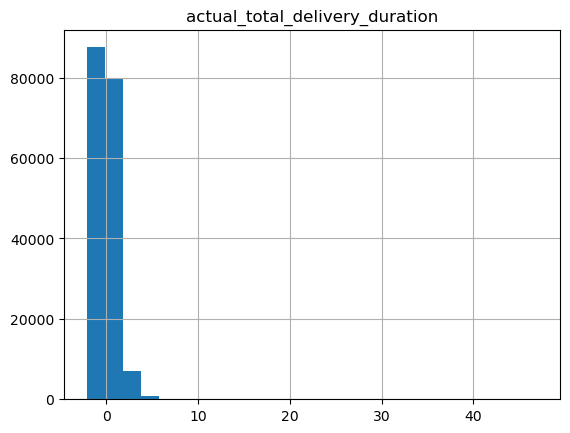

In [ ]:
# What is the distribution of the actual_total_delivery_time values around the mean?
x = train_df[['actual_total_delivery_duration']].apply(stats.zscore)
x.hist(column='actual_total_delivery_duration',bins=25)

In [ ]:
## feature selection/dimensionality reduction with PCA

def build_train_test(dataset:pd.DataFrame,target_feature:str,test_size:int):
    try:
        X = dataset.drop(columns=target_feature)
        y = dataset[target_feature]
        x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=test_size,random_state=42)
        x_train,x_test = pd.DataFrame(x_train),pd.DataFrame(x_test)
    except Exception as ex:
        raise ex
    return x_train,x_test,y_train,y_test

def apply_standard_scaler(dataset):
#applies the standard scaler to a single dataset
    scaler = StandardScaler()
    try:
        if type(dataset) == pd.DataFrame:
            scaler = scaler.fit(dataset.values)
            dataset_scaled = scaler.transform(dataset.values)
            dataset_scaled = pd.DataFrame(dataset_scaled,index=dataset.index,columns=dataset.columns)
        else:
            scaler = scaler.fit(dataset)
            dataset_scaled = scaler.transform(dataset)
            test_stdScale = scaler.transform(dataset)
    except Exception as ex:
        raise ex
    return dataset_scaled,scaler

def transform_rmse_to_seconds(scaler,y_test,y_hat_scaled):
    try:
        y_hat_descaled = scaler.inverse_transform(y_hat_scaled.reshape(-1,1))
        rmse_descaled = mean_squared_error(y_pred=y_test,y_true=y_hat_descaled[:,0],squared=False)
    except Exception as ex:
        raise ex
    return y_hat_descaled,rmse_descaled

In [ ]:
def PCAcalc_expl_var(x_train,target_expl_variance:int):
## returns the number of components required to explain the target_expl_variance
# and a feature to component ratio to support automation of further dimensionality reduction
    pca = PCA()
    x_train_scaled = apply_standard_scaler(x_train)[0]
    try:
        pca = pca.fit(x_train_scaled)
        components = np.cumsum(pca.explained_variance_ratio_)
        components = [i for i in components if i <= target_expl_variance]
        feature_to_component_ratio = len(components)/x_train.shape[1]
    except Exception as ex:
        raise ex
    return components,feature_to_component_ratio

def PCAcalc_dim_reduction(x_train,x_test,desired_components:int):
## you know, dimensionality reduction
    pca = PCA(n_components=desired_components)
    x_train_scaled,x_test_scaled = apply_standard_scaler(x_train)[0],apply_standard_scaler(x_test)[0]
    try:
        pca = pca.fit(x_train_scaled)
        x_train_pca,x_test_pca = pca.transform(x_train_scaled),pca.transform(x_test_scaled)
    except Exception as ex:
        raise ex
    return x_train_pca,x_test_pca

In [ ]:
x_train,x_holdout,y_train,y_holdout = build_train_test(dataset=train_df,target_feature='actual_total_delivery_duration',test_size=0.2)

We need 97 features (out of 166 available) to explain 90 percent of the variance.


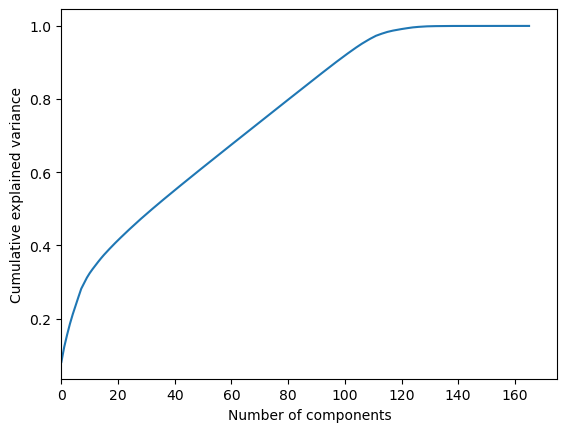

In [ ]:
## how many features are needed to explain 90% of the variance?
print("We need " + str(len(PCAcalc_expl_var(x_train=x_train,target_expl_variance=0.9)[0])) + " features (out of " + str(x_train.shape[1]) + " available) to explain 90 percent of the variance.")

x_train_scaled = apply_standard_scaler(x_train)[0]
pca = PCA().fit(x_train_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,175,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

#### Dimensionality reduction with PCA

In [ ]:
x_train_pca,x_test_pca = PCAcalc_dim_reduction(x_train=x_train,x_test=x_holdout,desired_components=len(PCAcalc_expl_var(x_train=x_train,target_expl_variance=0.9)[0]))

### Model functions, model selection and first round results

In [ ]:
def ApplyMethod_autoML(x_train,x_test,y_train,y_test,time_budget=int,metric=str,estimator_list=list,task=str,run_cv=bool,cv_folds=int,file_path=str,model_name=str):
    auto_ml = AutoML()
    kf = KFold(n_splits=cv_folds,random_state=42,shuffle=True)
    cv_scores = []
## recall that the actual_total_delivery_time data is gamma distributed
    class xgbGamma(XGBoostEstimator):
        def __init__(self, task="regression", **config):
            super().__init__(objective='reg:gamma', **config)
    auto_ml.add_learner(learner_name="xgb_gamma",learner_class=xgbGamma)
    try:
        auto_ml.fit(X_train=x_train,y_train=y_train,time_budget=time_budget,metric=metric,estimator_list=estimator_list,task=task,seed=42,verbose=0)
        trained_model = auto_ml
        ## store the model
        model_pickle = open(f'{file_path}/automl_{model_name}.pkl','wb')
        pickle.dump(auto_ml.model,model_pickle,pickle.HIGHEST_PROTOCOL)
        model_pickle.close()
        ## feature importances
        feature_importances_df = pd.DataFrame({'features':auto_ml.feature_names_in_,'importance':auto_ml.feature_importances_})
        ## cross-validation
        if run_cv == True:
            model_count = 1
            for train_index,test_index in kf.split(x_train):
                cv_xtrain,cv_xtest = x_train.iloc[train_index],x_train.iloc[test_index]
                cv_ytrain,cv_ytest = y_train.iloc[train_index],y_train.iloc[test_index]
                auto_ml.fit(X_train=cv_xtrain,y_train=cv_ytrain,time_budget=time_budget,metric=metric,estimator_list=[str(trained_model.best_estimator)],task=task,seed=42,verbose=0)
                ## predict, validate
                cv_yhat = auto_ml.predict(cv_xtest)
                if task == 'regression':
                    rmse = mean_squared_error(y_true=cv_ytest,y_pred=cv_yhat,squared=False)
                    cv_scores.append(rmse)
                if task == 'classification':
                    accuracy = accuracy_score(y_true=cv_ytest,y_pred=cv_yhat)
                    cv_scores.append(accuracy)
        if task == 'regression':
        ## test error
            y_hat_test = auto_ml.predict(x_test)
            test_RMSE = mean_squared_error(y_true=y_test,y_pred=y_hat_test,squared=False)
            test_MAE = mean_absolute_error(y_true=y_test,y_pred=y_hat_test)
            ## feature importances
            ## train error
            y_hat_train = auto_ml.predict(x_train)
            train_RMSE = mean_squared_error(y_true=y_train,y_pred=y_hat_train,squared=False)
            train_MAE = mean_absolute_error(y_true=y_train,y_pred=y_hat_train)
            eval_stats = {
                'train_RMSE:':train_RMSE,
                # gives context to the RMSE; the lower the ratio the better
                'train_RMSE_to_std_ratio':train_RMSE / (np.std(y_train)),
                'train_MAE:':train_MAE,
                'test_RMSE:':test_RMSE,
                # gives context to the RMSE; the lower the ratio the better
                'test_RMSE_to_std_ratio':test_RMSE / (np.std(y_test)),
                'test_MAE:':test_MAE
            }
        if task == 'classification':
            y_hat_test = auto_ml.predict(x_test)
            y_hat_test_proba = auto_ml.predict_proba(x_test)
            y_hat_train = auto_ml.predict(x_train)
            y_hat_train_proba = auto_ml.predict_proba(x_train)
            eval_stats = {
                'train_accuracy': accuracy_score(y_true=y_train,y_pred=y_hat_train),
                'train_roc_auc': roc_auc_score(y_true=y_train,y_score=y_hat_train_proba[:,1]),
                'test_accuracy': accuracy_score(y_true=y_test,y_pred=y_hat_test),
                'test_roc_auc': roc_auc_score(y_true=y_test,y_score=y_hat_test_proba[:,1])
            }
    except Exception as ex:
        raise ex
    return trained_model,feature_importances_df.sort_values(by='importance',ascending=False),eval_stats,cv_scores

In [ ]:
pca_regressions = ApplyMethod_autoML(
    x_train=x_train_pca,
    x_test=x_test_pca,
    y_train=y_train,
    y_test=y_holdout,
    time_budget=400,
    metric='mse',
    estimator_list=['xgb_gamma','xgboost','xgb_limitdepth'],
    task='regression',
    run_cv=False,
    cv_folds=5,
    file_path='singleModel_noSplit_pickles',
    model_name='xgbregression_pca'
    )
pca_regressions[2]

{'train_RMSE:': 922.044768243236,
 'train_RMSE_to_std_ratio': 0.7988714697866253,
 'train_MAE:': 612.6975717392198,
 'test_RMSE:': 1194.7149190518521,
 'test_RMSE_to_std_ratio': 1.0702272444393133,
 'test_MAE:': 905.0272597795322}

In [ ]:
auto_xgb_no_reduction = ApplyMethod_autoML(
    x_train=x_train,
    x_test=x_holdout,
    y_train=y_train,
    y_test=y_holdout,
    time_budget=400,
    metric='mse',
    estimator_list=['xgb_gamma','xgboost','xgb_limitdepth'],
    task='regression',
    run_cv=False,
    cv_folds=5,
    file_path='singleModel_noSplit_pickles',
    model_name='xgbreg_all_features'
)
auto_xgb_no_reduction[2]


check Spark installation...This line should appear only once.

use_spark=True requires installation of PySpark. Please run pip install flaml[spark]
        and check [here](https://spark.apache.org/docs/latest/api/python/getting_started/install.html)
        for more details about installing Spark.


{'train_RMSE:': 721.3968731672105,
 'train_RMSE_to_std_ratio': 0.6250275477020395,
 'train_MAE:': 513.6525913271923,
 'test_RMSE:': 833.177098601647,
 'test_RMSE_to_std_ratio': 0.746361174659176,
 'test_MAE:': 557.4898258667698}

In [ ]:
print("Cross-validation results (RMSE): ")
print(auto_xgb_no_reduction[3])
print("Mean of cross-validation results (RMSE): " + str(np.mean(auto_xgb_no_reduction[3])))
print("Best estimator: " + auto_xgb_no_reduction[0].best_estimator)
print("Best configuration: ")
print(auto_xgb_no_reduction[0].best_config)

Cross-validation results (RMSE): 
[928.0659595118198, 866.9700127007313, 861.5295421654322, 927.3771927147455, 899.9744304738704]
Mean of cross-validation results (RMSE): 896.7834275133198
Best estimator: xgb_limitdepth
Best configuration: 
{'n_estimators': 1028, 'max_depth': 6, 'min_child_weight': 1.4640336660392816, 'learning_rate': 0.02159558962109372, 'subsample': 0.8640052147174596, 'colsample_bylevel': 0.8726369812699186, 'colsample_bytree': 0.9407746256493329, 'reg_alpha': 0.0009765625, 'reg_lambda': 13.44701768864806}


In [ ]:
auto_xgb_no_reduction[1].sort_values(by='importance',ascending=False).head(10)

,features,importance
16,onshift_to_outstanding,0.082321
53,store_day_median_total_prep_time,0.054282
21,hour_mean_total_onshift_dashers,0.050517
20,hour_mean_total_outstanding_orders,0.032606
10,est_time_non-prep,0.031837
15,busy_to_outstanding,0.024344
49,store_day_of_week_est_time_prep_per_item_mean,0.023995
22,hour_mean_total_busy_dashers,0.023908
156,created_day_of_week__0,0.020687
31,hour_busy_outs_avg,0.019230


In [ ]:
top_features = auto_xgb_no_reduction[1]['features'][:97].to_list()

auto_xgb_top_features = ApplyMethod_autoML(
    x_train=x_train[top_features],
    x_test=x_holdout[top_features],
    y_train=y_train,
    y_test=y_holdout,
    time_budget=400,
    metric='mse',
    estimator_list=['xgb_gamma','xgboost','xgb_limitdepth'],
    task='regression',
    run_cv=False,
    cv_folds=5,
    file_path='singleModel_noSplit_pickles',
    model_name='xgbreg_top_thirtyfive_features'
)
auto_xgb_top_features[2]

{'train_RMSE:': 755.9607139874619,
 'train_RMSE_to_std_ratio': 0.6549741048200352,
 'train_MAE:': 534.3812971371257,
 'test_RMSE:': 845.7946618754502,
 'test_RMSE_to_std_ratio': 0.7576640049484116,
 'test_MAE:': 565.5202886412139}

In [ ]:
# does the first attempt at modeling improve on a baseline, average-derived model?
createBaseline(historical_data=train_df)

{'baseline_MAE:': 783.5442750429107, 'baseline_RMSE:': 19249.89784985233}

### Results so far


Performance statistics for my xgboost model against a holdout sample size of 0.2 are as follows:

    {'train_RMSE:': 775.2071297497488,
    'train_RMSE_to_std_ratio': 0.6716494474690015,
    'train_MAE:': 533.3797480868415,
    'test_RMSE:': 838.6686685160196,
    'test_RMSE_to_std_ratio': 0.7512805304346684,
    'test_MAE:': 559.3233676640386}

Cross-validation results (RMSE):

    [928.0659595118198, 866.9700127007313, 861.5295421654322, 927.3771927147455, 899.9744304738704]

Mean of cross-validation results (RMSE):

    896.7834275133198

Performance statistics for my xgboost model against a holdout size of 0.33:

    {'train_RMSE:': 873.4991,
    'train_RMSE_to_std_ratio': 0.7611590838185001,
    'train_MAE:': 581.7427,
    'test_RMSE:': 926.9857,
    'test_RMSE_to_std_ratio': 0.7968259664464706,
    'test_MAE:': 605.92535}

Holdout, train scores:

    {'train_RMSE:': 629.4737460788326,
    'train_RMSE_to_std_ratio': 0.5453841657604123,
    'train_MAE:': 455.779582570263,
    'test_RMSE:': 849.1551127581309,
    'test_RMSE_to_std_ratio': 0.7606743014056613,
    'test_MAE:': 557.112726920179}

cv RMSE scores:

    [684.0892768296953, 681.0979618118614, 677.0700958150553, 699.8305918514759, 691.835106692473]

Mean RMSE from cv:

    686.7846066001122

cv RMSE to y-true std:

    0.7761858125345661